(300, 451, 3)


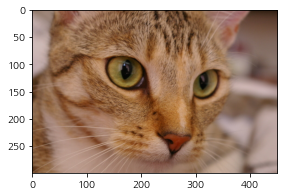

In [1]:
from skimage import data
import matplotlib.pyplot as plt

hr_image = data.chelsea() # skimage에서 제공하는 예제 이미지를 불러옵니다.
hr_shape = hr_image.shape[:2]

print(hr_image.shape) # 이미지의 크기를 출력합니다.

plt.figure(figsize=(6,3))
plt.imshow(hr_image)

이 고양이 이미지의 크기는 (세로 픽셀 수 x 가로 픽셀 수 x 채널 수) 가 [300 x 451 x 3] 으로 확인되네요. Interpolation을 통해 고양이를 매우 쉽게 Super Resolution 해보겠습니다.

우선 불러온 고양이가 꽤나 선명하기 때문에 일부러 크기를 줄여 저해상도로 낮춰보겠습니다. `opencv` 라이브러리의 `resize()`를 이용해 이미지의 크기를 조절할수 있습니다. 아래 코드에서는 고양이를 '100 x 150 x 3' 크기로 줄입니다. `dsize`의 설정값에 따라 크기를 조절하는데, 주의할 점은 변환하고자 하는 이미지의 크기를 (가로 픽셀 수, 세로 픽셀 수) 로 지정해줘야 합니다.

(100, 150, 3)


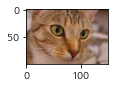

In [2]:
import cv2
lr_image = cv2.resize(hr_image, dsize=(150,100)) # (가로 픽셀 수, 세로 픽셀 수)

print(lr_image.shape)

plt.figure(figsize=(3,1))
plt.imshow(lr_image)

작아진 고양이 이미지로 Interpolation 방법을 적용해 Super Resolution을 시도해보겠습니다. `resize()`내의 `interpolation` 설정에 따라 적용 방법을 조절할 수 있습니다. 아래 코드는 이전에 간략하게 알아보았던 bilinear 및 bicubic interpolation을 적용해 이미지를 '400 x 600 x 3' 크기로 크게 변환하는 예제입니다.

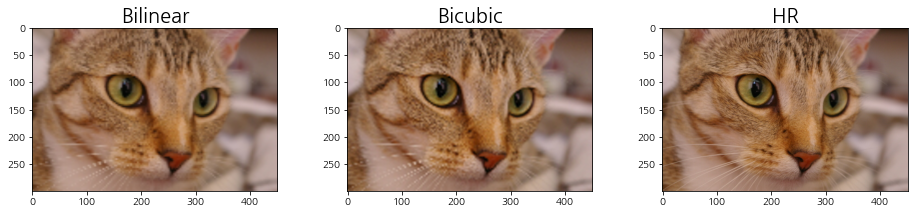

In [3]:
bilinear_image = cv2.resize(
    lr_image, 
    dsize=(451, 300), # (가로 픽셀 수, 세로 픽셀 수) 
    interpolation=cv2.INTER_LINEAR # bilinear interpolation 적용
)

bicubic_image = cv2.resize(
    lr_image, 
    dsize=(451, 300), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

images = [bilinear_image, bicubic_image, hr_image]
titles = ["Bilinear", "Bicubic", "HR"]

plt.figure(figsize=(16,3))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

이외 다른 interpolation 방법을 적용하고 싶다면 아래 링크를 참고해 주세요.
https://docs.opencv.org/master/da/d54/group__imgproc__transform.html#ga5bb5a1fea74ea38e1a5445ca803ff121

Bilinear 및 bicubic interpolation을 적용한 이미지와 원래 고해상도 이미지(위 그림의 HR)를 시각화했습니다. 이미지가 작아 시각적으로 해상도에 큰 차이가 없어 보입니다. 아래 코드를 이용해 특정 부분을 잘라내어 시각화해 봅시다.

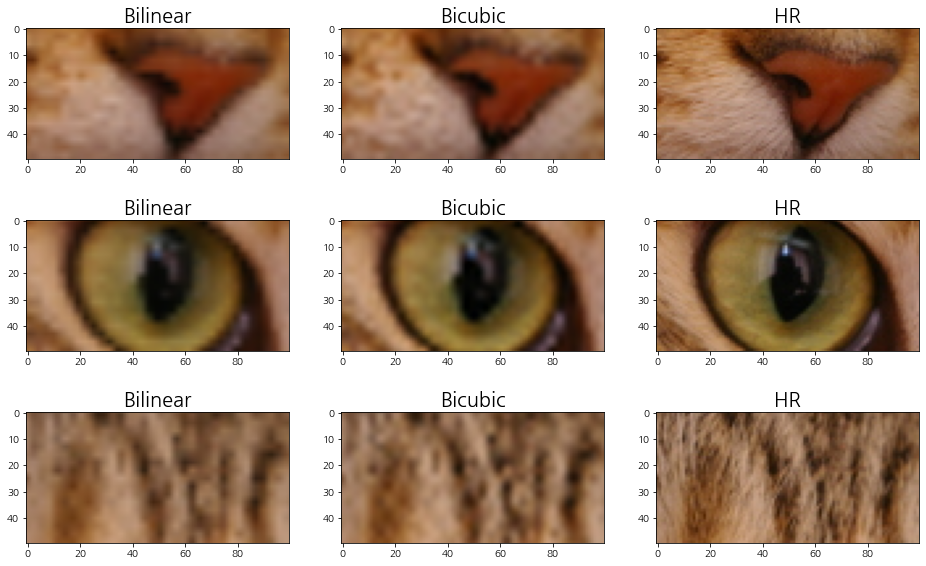

In [4]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]


# 잘라낼 영역의 좌표를 정의합니다.
left_tops = [(220,200)] *3 + [(90,120)] *3 + [(30,200)] *3

plt.figure(figsize=(16,10))
for i, (image, left_top, title) in enumerate(zip(images*3, left_tops, titles*3)):
    plt.subplot(3,3,i+1)
    plt.imshow(crop(image, left_top))
    plt.title(title, fontsize=20)

`tensorflow-datasets` 라이브러리에서 우리가 사용해 볼 데이터셋은 `DIV2K` 입니다. DIV2K 데이터셋은 많은 Super Resolution 연구에서 학습 및 평가에 사용되는 데이터셋이며 800개의 학습용 데이터셋 및 100개의 검증용 데이터셋으로 구성되어 있습니다.  

앞서 다운로드 한 데이터셋은 `div2k/bicubic_x4` 이며, 이는 `DIV2K` 데이터셋 중에서 실제 고해상도 이미지를 대상으로 bicubic interpolation을 이용해 가로 및 세로 픽셀 수를 1/4배로 줄인 데이터셋 입니다. 이렇게 만들어진 저해상도 이미지와 원래 고해상도 이미지가 서로 한 쌍으로 구성되어 있습니다.  

[참고 자료: DIV2K datasets](https://data.vision.ee.ethz.ch/cvl/DIV2K/)

## 데이터 준비하기
아래 코드를 이용해 DIV2K 데이터셋을 불러옵니다. 아래 코드에서 생성한 train과 valid는 각각 저해상도 및 고해상도 이미지를 쌍으로 담고 있습니다. 그중 한 쌍의 이미지에 대해 시각화해봅시다. 저해상도 이미지를 bicubic interpolation하여 고해상도 이미지와 동일한 크기로 만들었습니다.

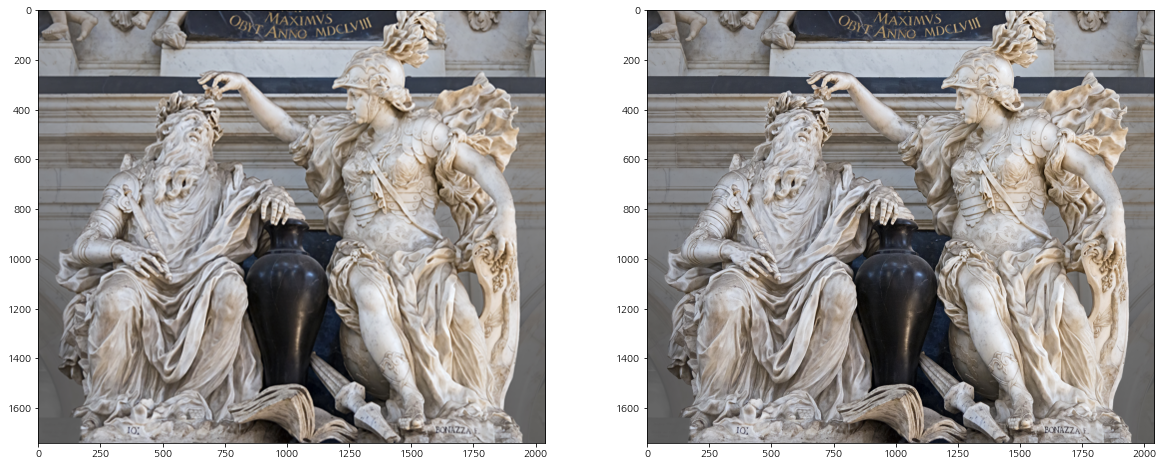

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# 데이터를 불러옵니다.
train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

# 시각화를 위해 한 개의 데이터만 선택합니다.
for i, (lr, hr) in enumerate(valid):
    if i == 6: break
    
# 저해상도 이미지를 고해상도 이미지 크기로 bicubic interpolation 합니다.  
hr, lr = np.array(hr), np.array(lr)
bicubic_hr = cv2.resize(
    lr, 
    dsize=(hr.shape[1], hr.shape[0]), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

# 저해상도 및 고해상도 이미지를 시각화합니다.
plt.figure(figsize=(20,10))
plt.subplot(1,2,1); plt.imshow(bicubic_hr)
plt.subplot(1,2,2); plt.imshow(hr)

이미지 크기가 꽤 크기 때문에 어렴풋이 봐서는 선명함의 차이가 크지 않은 것 같습니다. 아래 코드를 이용해 각 이미지의 특정 부분을 확대해봅시다.

Text(0.5, 1.0, 'HR')

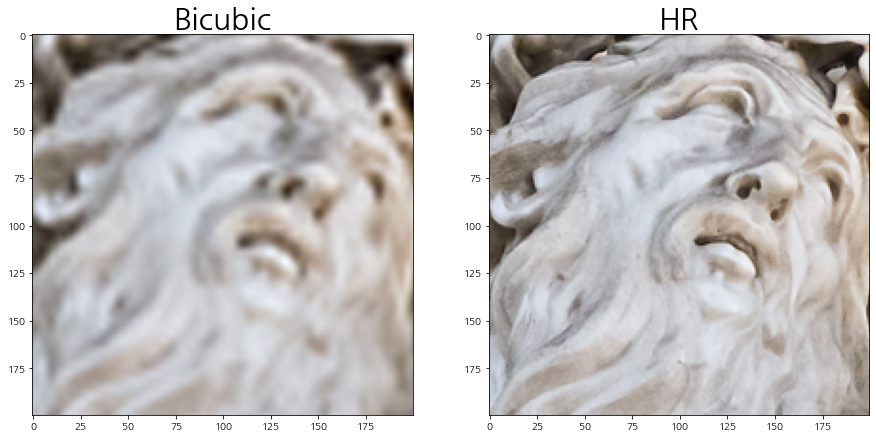

In [6]:
# 이미지의 특정 부분을 잘라내는 함수를 정의합니다.
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

# interpolation된 이미지와 고해상도 이미지의 동일한 부분을 각각 잘라냅니다.
left_top = (400, 500)
crop_bicubic_hr = crop(bicubic_hr, left_top)
crop_hr = crop(hr, left_top)

# 잘라낸 부분을 시각화 합니다.
plt.figure(figsize=(15,25))
plt.subplot(1,2,1); plt.imshow(crop_bicubic_hr); plt.title("Bicubic", fontsize=30)
plt.subplot(1,2,2); plt.imshow(crop_hr); plt.title("HR", fontsize=30)

Bicubic interpolation 방법을 이용한 결과는 HR이라 쓰여진 실제 고해상도 이미지와 비교하면 매우 선명하지 않은 것을 확인 할 수 있습니다. SRCNN을 이용해 학습한 결과는 얼마나 좋을지 아래에서 확인해 봅시다😆


앞서 언급되었듯이 **SRCNN의 입력**은 저해상도 이미지를 그대로 사용하는 것이 아닌, **만들고자 하는 고해상도 이미지 크기에 맞게 interpolation이 적용된 이미지**입니다. 이 과정을 아래 코드와 같이 수행합니다. 사용할 DIV2K 데이터셋 내의 개별 이미지 크기가 크므로, 일부 영역을 임의로 잘라내어 학습에 활용해 보겠습니다.

In [7]:
import tensorflow as tf

def preprocessing(lr, hr):
    # 이미지의 크기가 크므로 (96,96,3) 크기로 임의 영역을 잘라내어 사용합니다.
    hr = tf.image.random_crop(hr, size=[96, 96, 3])
    hr = tf.cast(hr, tf.float32) / 255.
    
    # 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄였다가
    # interpolation을 이용해 다시 원래 크기로 되돌립니다.
    # 이렇게 만든 저해상도 이미지를 입력으로 사용합니다.
    lr = tf.image.resize(hr, [96//4, 96//4], "bicubic")
    lr = tf.image.resize(lr, [96, 96], "bicubic")
    return lr, hr

train = train.map(preprocessing).shuffle(buffer_size=10).batch(16)
valid = valid.map(preprocessing).batch(16)
print("✅")

✅


## SRCNN 구현하기
앞서 살펴본 대로 SRCNN은 3개 convolutional layer를 사용한 구조를 가지고 있습니다. 따라서 아래 코드와 같이 Sequential API를 활용해 간단하게 구현할 수 있습니다.

In [8]:
from tensorflow.keras import layers, Sequential

# 3개의 convolutional layer를 갖는 Sequential 모델을 구성합니다.
srcnn = Sequential()
# 9x9 크기의 필터를 128개 사용합니다.
srcnn.add(layers.Conv2D(128, 9, padding="same", input_shape=(None, None, 3)))
srcnn.add(layers.ReLU())
# 5x5 크기의 필터를 64개 사용합니다.
srcnn.add(layers.Conv2D(64, 5, padding="same"))
srcnn.add(layers.ReLU())
# 5x5 크기의 필터를 64개 사용합니다.
srcnn.add(layers.Conv2D(3, 5, padding="same"))

srcnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 128)   31232     
_________________________________________________________________
re_lu (ReLU)                 (None, None, None, 128)   0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    204864    
_________________________________________________________________
re_lu_1 (ReLU)               (None, None, None, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 3)     4803      
Total params: 240,899
Trainable params: 240,899
Non-trainable params: 0
_________________________________________________________________


## SRCNN 학습하기
최적화 방법과 손실 함수를 설정하고, 앞서 전처리한 데이터를 이용해 아래와 같이 간단하게 학습할 수 있습니다. 우선 1 epoch만 학습 시켜 봅시다.

In [1]:
srcnn.compile(
    optimizer="adam", 
    loss="mse"
)

srcnn.fit(train, validation_data=valid, epochs=1)

NameError: name 'srcnn' is not defined

## SRCNN 테스트하기
SRCNN의 학습에는 꽤나 오랜시간이 소요되어 여기서 SRCNN을 처음부터 끝까지 학습시키지 않겠습니다. 대신 SRCNN을 사용해보기 위해 이미 학습이 완료된 SRCNN 모델을 준비했습니다😅 아래 `srcnn.h5` 파일을 다운로드받은 후 코드를 실행하여 학습 완료된 모델을 불러올 수 있습니다.  

\$ mkdir -p ~/aiffel/super_resolution  

\$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/srcnn.h5  

\$ mv srcnn.h5 ~/aiffel/super_resolution  

In [ ]:
import tensorflow as tf
import os

model_file = os.getenv('HOME')+'/aiffel/super_resolution/srcnn.h5'
srcnn = tf.keras.models.load_model(model_file)

아래 코드와 같이 저해상도 이미지를 입력받아 SRCNN을 사용하는 함수를 간단하게 정의하고, 이 함수를 이용해 SRCNN의 결과인 고해상도 이미지를 얻어봅시다.

In [ ]:
def apply_srcnn(image):
    sr = srcnn.predict(image[np.newaxis, ...]/255.)
    sr[sr > 1] = 1
    sr[sr < 0] = 0
    sr *= 255.
    return np.array(sr[0].astype(np.uint8))

srcnn_hr = apply_srcnn(bicubic_hr)

이전 bicubic interpolation을 적용하고 이미지 전체를 시각화했을 때 세부적인 선명함이 눈에 띄지 않았기 때문에, 일부 영역을 잘라내어 시각적으로 비교해보겠습니다. 아래 코드를 이용해 3개 이미지(bicubic interpolation의 결과, SRCNN의 결과, 원래 고해상도 이미지)를 나란히 시각화합니다.

In [ ]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(400,500), (300,1200), (0,1000)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srcnn_hr , left_top, 200, 200)
    img3 = crop(hr, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRCNN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

시각화 결과 bicubic interpolation 결과보다 조금 더 선명해졌지만 원래 고해상도 이미지에 비해 만족할만한 성능은 아닌 것 같습니다. DIV2K 데이터셋이 비교적 세밀한 구조의 이미지가 많아 SRCNN과 같이 간단한 구조로는 더 이상 학습되지 않는 것으로 보입니다.

실제로 SRCNN 논문에서는 아래와 같이 비교적 간단한 구조의 이미지에 대해서는 꽤나 만족할 만한 성능을 보여줍니다.

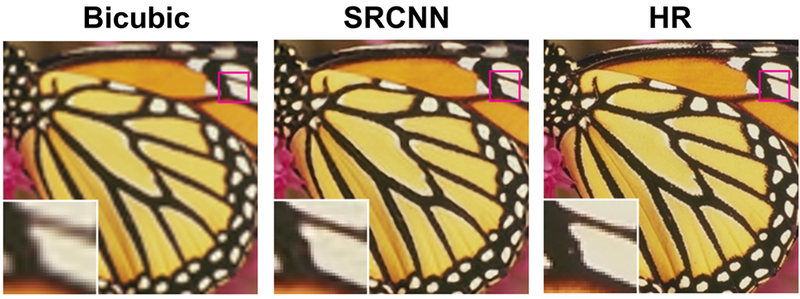

## SRGAN을 이용해 Super Resolution 도전하기

### 데이터 준비하기
SRCNN은 저해상도 이미지에 대해 interpolation하여 고해상도 이미지 크기로 맞춘 후 입력으로 사용했지만, SRGAN은 그러한 과정을 거치지 않습니다.

In [2]:
train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)
def preprocessing(lr, hr):
    hr = tf.cast(hr, tf.float32) /255.
        
    # 이미지의 크기가 크므로 (96,96,3) 크기로 임의 영역을 잘라내어 사용합니다.
    hr_patch = tf.image.random_crop(hr, size=[96,96,3])
        
    # 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄입니다
    # 이렇게 만든 저해상도 이미지를 SRGAN의 입력으로 사용합니다.
    lr_patch = tf.image.resize(hr_patch, [96//4, 96//4], "bicubic")
    return lr_patch, hr_patch

train = train.map(preprocessing).shuffle(buffer_size=10).repeat().batch(8)
valid = valid.map(preprocessing).repeat().batch(8)
print("✅")

NameError: name 'tfds' is not defined

### SRGAN 구현하기
저해상도 이미지를 입력받아 고해상도 이미지를 생성하는 Generator를 구현해 봅시다! SRGAN의 Generator 부분은 아래와 같습니다. 
SRGAN의 Generator에는 skip-connection을 가지고 있으며, 이는 Sequential API로 구현할 수 없으므로 Functional API를 이용해 아래와 같이 구현해 보겠습니다. 위 Generator 그림에서 각 layer를 따라 비교하면서 아래 코드를 이해해 봅시다.

In [ ]:
from tensorflow.keras import Input, Model

# 그림의 파란색 블록을 정의합니다.
def gene_base_block(x):
    out = layers.Conv2D(64, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.PReLU(shared_axes=[1,2])(out)
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.Add()([x, out])

# 그림의 뒤쪽 연두색 블록을 정의합니다.
def upsample_block(x):
    out = layers.Conv2D(256, 3, 1, "same")(x)
    # 그림의 PixelShuffler 라고 쓰여진 부분을 아래와 같이 구현합니다.
    out = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(out)
    return layers.PReLU(shared_axes=[1,2])(out)
    
# 전체 Generator를 정의합니다.
def get_generator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 9, 1, "same")(inputs)
    out = residual = layers.PReLU(shared_axes=[1,2])(out)
    
    for _ in range(5):
        out = gene_base_block(out)
    
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.Add()([residual, out])
    
    for _ in range(2):
        out = upsample_block(out)
        
    out = layers.Conv2D(3, 9, 1, "same", activation="tanh")(out)
    return Model(inputs, out)

print("✅")

이번에는 생성된 고해상도 이미지와 진짜 고해상도 이미지 사이에서 진짜를 판별해내는 Discriminator를 아래 그림에 따라 구현해 보겠습니다. 마찬가지로 Functional API를 사용합니다.

In [ ]:
# 그림의 파란색 블록을 정의합니다.
def disc_base_block(x, n_filters=128):
    out = layers.Conv2D(n_filters, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(n_filters, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.LeakyReLU()(out)

# 전체 Discriminator 정의합니다.
def get_discriminator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 3, 1, "same")(inputs)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(64, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    
    for n_filters in [128, 256, 512]:
        out = disc_base_block(out, n_filters)
    
    out = layers.Dense(1024)(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(1, activation="sigmoid")(out)
    return Model(inputs, out)

print("✅")

SRGAN은 VGG19를 이용해 content loss를 계산합니다. Tensorflow는 이미지넷 데이터로부터 잘 학습된 VGG19를 제공하고 있으며 이를 이용해 보겠습니다.

In [ ]:
# SRGAN은 VGG19를 이용해 content loss를 계산  
from tensorflow.python.keras import applications
def get_feature_extractor(input_shape=(None, None, 3)):
    vgg = applications.vgg19.VGG19(
        include_top=False, 
        weights="imagenet", 
        input_shape=input_shape
    )
    # 아래 vgg.layers[20]은 vgg 내의 마지막 convolutional layer 입니다.
    return Model(vgg.input, vgg.layers[20].output)

print("✅")

### SRGAN 학습하기
이제부터는 앞에서 정의한 신경망들을 이용해 SRGAN을 학습해 보겠습니다. 이전에 SRCNN과 마찬가지로 학습에 꽤나 오랜 시간이 소요되므로 SRGAN의 학습을 처음부터 전부 진행하진 않겠습니다. 여기서는 200번의 반복만 진행해보겠습니다.
(초반 학습이 불안정하여 Generator의 loss가 증가할 수도 있습니다)

In [ ]:
from tensorflow.keras import losses, metrics, optimizers

generator = get_generator()
discriminator = get_discriminator()
vgg = get_feature_extractor()

# 사용할 loss function 및 optimizer 를 정의합니다.
bce = losses.BinaryCrossentropy(from_logits=False)
mse = losses.MeanSquaredError()
gene_opt = optimizers.Adam()
disc_opt = optimizers.Adam()

def get_gene_loss(fake_out):
    return bce(tf.ones_like(fake_out), fake_out)

def get_disc_loss(real_out, fake_out):
    return bce(tf.ones_like(real_out), real_out) + bce(tf.zeros_like(fake_out), fake_out)


@tf.function
def get_content_loss(hr_real, hr_fake):
    hr_real = applications.vgg19.preprocess_input(hr_real)
    hr_fake = applications.vgg19.preprocess_input(hr_fake)
    
    hr_real_feature = vgg(hr_real) / 12.75
    hr_fake_feature = vgg(hr_fake) / 12.75
    return mse(hr_real_feature, hr_fake_feature)


@tf.function
def step(lr, hr_real):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        hr_fake = generator(lr, training=True)
        
        real_out = discriminator(hr_real, training=True)
        fake_out = discriminator(hr_fake, training=True)
        
        perceptual_loss = get_content_loss(hr_real, hr_fake) + 1e-3 * get_gene_loss(fake_out)
        discriminator_loss = get_disc_loss(real_out, fake_out)
        
    gene_gradient = gene_tape.gradient(perceptual_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return perceptual_loss, discriminator_loss


gene_losses = metrics.Mean()
disc_losses = metrics.Mean()

for epoch in range(1, 2):
    for i, (lr, hr) in enumerate(train):
        g_loss, d_loss = step(lr, hr)
        
        gene_losses.update_state(g_loss)
        disc_losses.update_state(d_loss)
        
        # 10회 반복마다 loss를 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \nGenerator_loss:{gene_losses.result():.4f} \nDiscriminator_loss:{disc_losses.result():.4f}", end="\n\n")
        
        if (i+1) == 200:
            break
            
    gene_losses.reset_states()
    disc_losses.reset_states()

## SRGAN 테스트하기
SRGAN이 만족스러운 결과를 도출할 때까지는 상당히 많은 학습 시간을 요구합니다. 이전과 마찬가지로 이미 학습이 완료된 SRGAN을 미리 준비해 놓았습니다😅 이를 이용해 테스트해 봅시다.

SRGAN은 크게 두 개의 신경망(Generator, Discriminator)으로 구성되어 있지만, 테스트에는 저해상도 입력을 넣어 고해상도 이미지를 출력하는 Generator만 이용합니다. 아래 `srgan_G.h5` 파일은 학습이 완료된 Generator이며, 이를 다운로드받아 코드를 실행해 학습 완료된 모델을 불러옵니다. 

\$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/srgan_G.h5

\$ mv srgan_G.h5 ~/aiffel/super_resolution

In [ ]:
import tensorflow as tf
import os

model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

아래 코드와 같이 테스트 과정을 진행하는 함수를 간단하게 정의하고, 이 함수를 이용해 이전에 사용했던 이미지에 대해 SRGAN의 고해상도 결과를 생성합니다.

In [ ]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

for i, (lr, hr) in enumerate(valid):
    if i == 6: break

srgan_hr = apply_srgan(lr)
print("✅")

이미지 전체를 시각화했을 때 세부적인 선명함이 눈에 띄지 않았기 때문에, 일부 영역을 잘라내어 시각적으로 비교해보겠습니다. 아래 코드를 이용해 3개 이미지(bicubic interpolation의 결과, SRGAN의 결과, 원래 고해상도 이미지)를 나란히 시각화합니다.

In [ ]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(400,500), (300,1200), (0,1000)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    img3 = crop(hr, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

시각화 결과 bicubic interpolation보다 훨씬 더 원래 고해상도 이미지에 가까운, 꽤나 만족할만한 결과를 얻은 것 같습니다! 이전에 사용했던 SRCNN 보다 더 깊은 신경망 구조를 사용했고, GAN 및 VGG 구조를 이용한 손실 함수를 사용해 복잡하게 학습 과정을 구성한 보람이 있네요😆 

## Super Resolution 결과 평가
- 평가 지표: PSNR, SSIM

In [ ]:
from skimage import data
import matplotlib.pyplot as plt

hr_cat = data.chelsea() # skimage에서 제공하는 예제 이미지를 불러옵니다.
hr_shape = hr_cat.shape[:2]

print(hr_cat.shape) # 이미지의 크기를 출력합니다.

plt.figure(figsize=(8,5))
plt.imshow(hr_cat)

동일한 이미지로 PSNR과 SSIM을 계산해 보겠습니다. 아래 코드와 같이 `peak_signal_noise_ratio` , `structural_similarity` 두 메서드를 이용하면 쉽게 계산할 수 있습니다.

In [ ]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

print("**동일 이미지 비교**")
print("PSNR :", peak_signal_noise_ratio(hr_cat, hr_cat))
print("SSIM :", structural_similarity(hr_cat, hr_cat, multichannel=True))

PSNR과 SSIM 모두 높은 값을 가질수록 원본 이미지와 가깝다는 것을 의미하며, 동일한 이미지를 비교했기 때문에 두 결과는 각각 가질 수 있는 최댓값을 가집니다. PSNR은 상한값이 없고, SSIM은 0~1 사이의 값을 가지기 때문에 각각 inf와 1이 계산됩니다.

이번에는 아래 코드를 이용해 고양이의 가로 세로 픽셀 수를 각각 1/2, 1/4, 1/8로 줄이고, bicubic interpolation을 이용해 원래 크기로 복원해 보겠습니다. 각각 처리된 이미지에 대해 원본 이미지와의 PSNR과 SSIM을 계산하고 그 결과를 제목에 표시해 보겠습니다.  

각 이미지의 제목에 PSNR과 SSIM이 순서대로 나타났습니다. 해상도를 줄일수록 그 이미지를 원래 크기로 interploation 했을 때, 각각의 계산 결과가 눈에 띄게 감소하는 것을 알 수 있습니다.

In [3]:
import cv2

# 이미지를 특정 크기로 줄이고 다시 늘리는 과정을 함수로 정의합니다.
def interpolation_xn(image, n):
    downsample = cv2.resize(
        image,
        dsize=(hr_shape[1]//n, hr_shape[0]//n)
    )
    upsample = cv2.resize(
        downsample,
        dsize=(hr_shape[1], hr_shape[0]),
        interpolation=cv2.INTER_CUBIC
    )
    return upsample

lr2_cat = interpolation_xn(hr_cat, 2) # 1/2로 줄이고 다시 복원
lr4_cat = interpolation_xn(hr_cat, 4) # 1/4로 줄이고 다시 복원
lr8_cat = interpolation_xn(hr_cat, 8) # 1/8로 줄이고 다시 복원

images = [hr_cat, lr2_cat, lr4_cat, lr8_cat]
titles = ["HR", "x2", "x4", "x8"]

# 각 이미지에 대해 PSNR을 계산하고 반올림합니다.
psnr = [round(peak_signal_noise_ratio(hr_cat, i), 3) for i in images]
# 각 이미지에 대해 SSIM을 계산하고 반올림합니다.
ssim = [round(structural_similarity(hr_cat, i, multichannel=True), 3) for i in images]

# 이미지 제목에 PSNR과 SSIM을 포함하여 시각화 합니다. 
plt.figure(figsize=(16,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(images[i])
    plt.title(titles[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=20)

NameError: name 'hr_cat' is not defined

## SRCNN 및 SRGAN 결과 비교
이번에는 앞서 실험했던 SRCNN과 SRGAN의 결과를 먼저 시각적으로만 비교해 보겠습니다. 이전에 불러온 DIV2K 데이터셋 내에서 학습에 사용하지 않은 검증용 데이터셋을 이용하며, 몇 개 이미지만 뽑아서 Super Resolution을 진행한 후 특정 부분을 잘라내어 확대해봅시다.  
자동차의 앞부분을 잘라내어 확대했습니다. HR이라는 제목을 가진 고해상도 이미지와 비교할 때, Bicubic과 SRCNN은 많이 흐릿하지만 SRGAN의 결과는 매우 비슷하네요😃

In [ ]:
    for i, (lr, hr) in enumerate(valid):
    if i == 12: break # 12번째 이미지를 불러옵니다.

lr_img, hr_img = np.array(lr), np.array(hr)

# bicubic interpolation
bicubic_img = cv2.resize(
    lr_img, 
    (hr.shape[1], hr.shape[0]), 
    interpolation=cv2.INTER_CUBIC
)

# 전체 이미지를 시각화합니다.
plt.figure(figsize=(20,15))
plt.subplot(311); plt.imshow(hr_img)

# SRCNN을 이용해 고해상도로 변환합니다.
srcnn_img = apply_srcnn(bicubic_img)

# SRGAN을 이용해 고해상도로 변환합니다.
srgan_img = apply_srgan(lr_img)

images = [bicubic_img, srcnn_img, srgan_img, hr_img]
titles = ["Bicubic", "SRCNN", "SRGAN", "HR"]

left_top = (700, 1090) # 잘라낼 부분의 왼쪽 상단 좌표를 지정합니다.

# bicubic, SRCNN, SRGAN 을 적용한 이미지와 원래의 고해상도 이미지를 시각화합니다.
plt.figure(figsize=(20,20))
for i, pind in enumerate([321, 322, 323, 324]):
    plt.subplot(pind)
    plt.imshow(crop(images[i], left_top, 200, 350))
    plt.title(titles[i], fontsize=30)

In [ ]:
for i, (lr, hr) in enumerate(valid):
    if i == 15: break

lr_img, hr_img = np.array(lr), np.array(hr)
bicubic_img = cv2.resize(
    lr_img, 
    (hr.shape[1], hr.shape[0]), 
    interpolation=cv2.INTER_CUBIC
)

plt.figure(figsize=(20,15))
plt.subplot(311); plt.imshow(hr_img)

srcnn_img = apply_srcnn(bicubic_img)
srgan_img = apply_srgan(lr_img)

images = [bicubic_img, srcnn_img, srgan_img, hr_img]
titles = ["Bicubic", "SRCNN", "SRGAN", "HR"]

left_top = (600, 1500)

plt.figure(figsize=(20,20))
for i, pind in enumerate([321, 322, 323, 324]):
    plt.subplot(pind)
    plt.imshow(crop(images[i], left_top, 200, 350))
    plt.title(titles[i], fontsize=30)

In [ ]:
for i, (lr, hr) in enumerate(valid):
    if i == 8: break

lr_img, hr_img = np.array(lr), np.array(hr)
bicubic_img = cv2.resize(
    lr_img, 
    (hr.shape[1], hr.shape[0]), 
    interpolation=cv2.INTER_CUBIC
)

plt.figure(figsize=(20,15))
plt.subplot(311); plt.imshow(hr_img)

srcnn_img = apply_srcnn(bicubic_img)
srgan_img = apply_srgan(lr_img)

images = [bicubic_img, srcnn_img, srgan_img, hr_img]
titles = ["Bicubic", "SRCNN", "SRGAN", "HR"]

left_top = (900, 1500)

plt.figure(figsize=(20,20))
for i, pind in enumerate([321, 322, 323, 324]):
    plt.subplot(pind)
    plt.imshow(crop(images[i], left_top, 200, 350))
    plt.title(titles[i], fontsize=30)

In [ ]:
for i, (lr, hr) in enumerate(valid):
    # 불러올 이미지의 인덱스를 지정합니다.
    # 위에서 시각화 했던 8, 12, 15, 24 번을 제외한 다른 숫자를 넣어봅시다 
    if i == ##TODO## : 
        break          
lr_img, hr_img = np.array(lr), np.array(hr)
bicubic_img = cv2.resize(
    lr_img,
    (hr.shape[1], hr.shape[0]),
    interpolation=cv2.INTER_CUBIC
)
# 확대할 부분의 왼쪽 상단 좌표를 지정합니다.
left_top = ##TODO## 
srcnn_img = apply_srcnn(bicubic_img)
srgan_img = apply_srgan(lr_img)
images = [bicubic_img, srcnn_img, srgan_img, hr_img]
# crop 함수 내의 세번째 네번째 인자를 수정해 이미지 크기를 조절합니다.
crop_images = [crop(i, left_top, 150, 250) for i in images] 
titles = ["Bicubic", "SRCNN", "SRGAN", "HR"]
psnr = [round(peak_signal_noise_ratio(crop_images[-1], i), 3) for i in crop_images]
ssim = [round(structural_similarity(crop_images[-1], i, multichannel=True), 3) for i in crop_images]
plt.figure(figsize=(18,10)) # 이미지 크기를 조절할 수 있습니다.
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(crop_images[i])
    plt.title(titles[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=30)

래 코드에서는 여러분이 직접 이미지를 고르고, 잘라내어 확대할 부분을 지정하여 실행해 봅시다. 코드 내 `##TODO##` 라고 쓰여진 두 부분을 입력하면 됩니다.


이번에는 각 Super Resolution 결과와 원래 고해상도 이미지 사이의 PSNR, SSIM을 계산해 보겠습니다. 이전과 마찬가지로 아래 코드를 이용해 각 이미지의 제목에 평가 결과를 함께 표시하도록 합니다.

In [ ]:
for i, (lr, hr) in enumerate(valid):
    if i == 24: break
    
lr_img, hr_img = np.array(lr), np.array(hr)
bicubic_img = cv2.resize(
    lr_img,
    (hr.shape[1], hr.shape[0]),
    interpolation=cv2.INTER_CUBIC
)

srcnn_img = apply_srcnn(bicubic_img)
srgan_img = apply_srgan(lr_img)

images = [bicubic_img, srcnn_img, srgan_img, hr_img]
titles = ["Bicubic", "SRCNN", "SRGAN", "HR"]

# 각 이미지에 대해 PSNR을 계산하고 반올림합니다.
psnr = [round(peak_signal_noise_ratio(hr_img, i), 3) for i in images]
# 각 이미지에 대해 SSIM을 계산하고 반올림합니다.
ssim = [round(structural_similarity(hr_img, i, multichannel=True), 3) for i in images]

# 이미지 제목에 PSNR과 SSIM을 포함하여 시각화 합니다. 
plt.figure(figsize=(18,13))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(images[i])
    plt.title(titles[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=30)

어떻게 된 일인지 시각적으로 가장 고해상도 이미지에 가까웠던 SRGAN의 결과가 다른 방법들에 비해 낮은 PSNR과 SSIM 결과를 가집니다. 아래에서 이 이미지에 대해 특정 부분을 잘라내고, 잘라낸 이미지로 PSNR, SSIM을 계산해 봅시다.

건물의 창문 부분을 잘라 자세히 보겠습니다.

In [ ]:
left_top = (620, 570)
crop_images = [crop(i, left_top, 150, 250) for i in images]

psnr = [round(peak_signal_noise_ratio(crop_images[-1], i), 3) for i in crop_images]
ssim = [round(structural_similarity(crop_images[-1], i, multichannel=True), 3) for i in crop_images]

plt.figure(figsize=(18,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(crop_images[i])
    plt.title(titles[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=30)

SRCNN 결과의 경우 약간 선명해졌지만 전체적으로 여전히 고해상도 영상에 비해 흐릿합니다. SRCNN의 학습에 Mean Squared Error를 사용했기 때문에, 생성해야 할 픽셀 값들을 고해상도 이미지와 비교해 단순히 평균적으로 잘 맞추는 방향으로 예측했기 때문입니다. 이러한 문제는 SRCNN 뿐만 아니라 MSE만을 사용해 학습하는 대부분의 신경망에서 발생하는 현상이기도 합니다.

SRGAN 결과의 경우 매우 선명하게 이상함을 확인할 수 있습니다. 이는 Generator가 고해상도 이미지를 생성하는 과정에서 Discriminator를 속이기 위해 이미지를 진짜 같이 선명하게 만들도록 학습 되었기 때문입니다. 추가로 앞서 설명했듯이 VGG구조를 이용한 content loss를 통해 학습한 것 또한 사실적인 이미지를 형성하는데 크게 기여했다고 합니다. 다만, 입력되었던 저해상도 이미지가 매우 제한된 정보를 가지고 있기에 고해상도 이미지와 세부적으로 동일한 모양으로 선명하진 않은 것이죠.

아래 코드에서는 여러분이 직접 이미지를 골라 잘라내고, 그 영역에 대해서만 PSNR과 SSIM을 계산하여 제목에 표시해 봅시다. 데이터 및 잘라낸 위치에 따라 위와 반대로 SRGAN의 정량적 평가가 더 좋게 나오는 부분이 있을 것입니다. 코드 내 ##TODO## 라고 쓰여진 부분을 입력하면 됩니다.

In [ ]:
for i, (lr, hr) in enumerate(valid):
    # 불러올 이미지의 인덱스를 지정합니다.
    # 위에서 시각화 했던 8, 12, 15, 24 번을 제외한 다른 숫자를 넣어봅시다 
    if i == 13 : 
        break          

lr_img, hr_img = np.array(lr), np.array(hr)
bicubic_img = cv2.resize(
    lr_img,
    (hr.shape[1], hr.shape[0]),
    interpolation=cv2.INTER_CUBIC
)

# 확대할 부분의 왼쪽 상단 좌표를 지정합니다.
left_top = (700,1300) 

# crop 함수 내의 세번째 네번째 인자를 수정해 이미지 크기를 조절합니다.
crop_images = [crop(i, left_top, 150, 250) for i in images] 
titles = ["Bicubic", "SRCNN", "SRGAN", "HR"]

psnr = [round(peak_signal_noise_ratio(crop_images[-1], i), 3) for i in crop_images]
ssim = [round(structural_similarity(crop_images[-1], i, multichannel=True), 3) for i in crop_images]

plt.figure(figsize=(18,10)) # 이미지 크기를 조절할 수 있습니다.
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(crop_images[i])
    plt.title(titles[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=30)